Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import

In [292]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns

# train-test split
from sklearn.model_selection import train_test_split

# 2. Load All Data

In [308]:
# LIMITED DATA
Bldg_Lim = []

# Read all building data and append to list
for path in pathlib.Path("/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Combined/dataset2").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg_Lim.append(current_file)

# BIG DATA
Bldg_Big = []

# Read all building data and append to list
for path in pathlib.Path("/content/drive/Shareddrives/Microclimate-Building Energy/Data/NN_big_data").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg_Big.append(current_file)

## 2.1 Preprocessing

1. Adding Month, Hour, and Minute to limited data
2. Removing hours out of ENVI-met accuracy range (after 9 pm) for limited data
3. Add CHWTON/SQFT to columns using condition area for each building taken from
    https://fdm-apps.asu.edu/UFRM/FDS/FacilityData.aspx
4. Drop na rows in limited data (some data points from campus metabolism not available)
5. Drop 'index' column and rename 'rel humid' to 'rel hum' for big data

In [309]:
## LIMITED DATA ##
# Create Month, Hour, and Minute column for all dataframes in list and drop unnecessary columns
for i in range(len(Bldg_Lim)):
    Bldg_Lim[i].Date_Time = pd.to_datetime(Bldg_Lim[i].Date_Time)
    Bldg_Lim[i]['Month'] = Bldg_Lim[i].Date_Time.dt.month
    Bldg_Lim[i]['Hour'] = Bldg_Lim[i].Date_Time.dt.hour
    Bldg_Lim[i]['Minute'] = Bldg_Lim[i].Date_Time.dt.minute
    Bldg_Lim[i]['Day'] = Bldg_Lim[i].Date_Time.dt.day
    Bldg_Lim[i] = Bldg_Lim[i].drop(columns = ['Date_Time'])

# Remove data after 9pm
for i in range(len(Bldg_Lim)):
    Bldg_Lim[i] = Bldg_Lim[i][(Bldg_Lim[i]['Hour'] <= 20) & (Bldg_Lim[i]['Hour'] > 0)]

# Add Column: CHWTON/Condition Area (SqFt) or ['CHWTON/SQFT']
cond_area = {'Noble Library':88658,'Biodesign B':132215,'Biodesign C':145410,
             'Biodesign A':133016,'Psychology':69864,'Goldwater':165237,'Schwada COB':99857,
             'ISTB 2':41404,'Bulldog Hall':68067,'ISTB 4':231646,'Psychology North':43034}
for i in range(len(Bldg_Lim)):
    if Bldg_Lim[i]['bldgname'][0] in cond_area:
        Bldg_Lim[i]['CHWTON/SQFT'] = Bldg_Lim[i]['CHWTON'] / cond_area[Bldg_Lim[i]['bldgname'][0]]

# Rearrange Columns
for i in range(len(Bldg_Lim)):
    cols = ['bldgname','Date','Time','Month','Day','Hour','Minute','Air Temp','Rel Hum','KW','CHWTON','CHWTON/SQFT']
    Bldg_Lim[i] = Bldg_Lim[i][cols]

# Drop NA rows in data
for i in range(len(Bldg_Lim)):
  Bldg_Lim[i] = Bldg_Lim[i].dropna()
  Bldg_Lim[i] = Bldg_Lim[i].reset_index(drop=True)

## BIG DATA ##
# Rename 'Rel Humid' to 'Rel Hum' and drop 'index' column
for i in range(len(Bldg_Big)):
  Bldg_Big[i] = Bldg_Big[i].rename(columns = {'Rel Humid': 'Rel Hum'})
  Bldg_Big[i] = Bldg_Big[i].drop(columns=['index'])

In [310]:
# Check if NA in data
for i in range(len(Bldg_Lim)):
  null_data = Bldg_Lim[i][Bldg_Lim[i].isnull().any(axis=1)]
  print(null_data)

Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Month, Day, Hour, Minute, Air Temp, Rel Hum, KW, CHWTON,

# 3. Single Building Analysis - Big Data

## 3.1 Select Building

In [288]:
# Ask user to select building
for i in range(len(Bldg_Big)):
    print(i, Bldg_Big[i]['bldgname'][0])

bldgnum_B = int(input("Enter the number of the building from the list above: "))

Bldg_Big[bldgnum_B]

0 Noble Library
1 Psychology
2 Goldwater
3 Biodesign B
4 Biodesign A
5 Biodesign C
6 ISTB 4
7 ISTB 2
8 Bulldog Hall
9 Schwada COB
10 Psychology North
Enter the number of the building from the list above: 2


,bldgname,Month,Day,Hour,Minute,Air Temp,Rel Hum,KW,CHWTON,CHWTON/SQFT
0,Goldwater,1,1,0,0,11.0,40.24,476.16,75.87,0.000459
1,Goldwater,1,1,0,15,11.0,40.24,474.88,73.43,0.000444
2,Goldwater,1,1,0,30,10.0,43.01,475.31,69.49,0.000421
3,Goldwater,1,1,0,45,9.0,46.00,475.08,66.81,0.000404
4,Goldwater,1,1,1,0,9.0,46.00,477.92,71.85,0.000435
...,...,...,...,...,...,...,...,...,...,...
34619,Goldwater,12,31,22,0,6.0,93.30,486.12,14.18,0.000086
34620,Goldwater,12,31,22,15,5.0,100.00,480.80,12.06,0.000073
34621,Goldwater,12,31,22,30,5.0,100.00,479.43,10.82,0.000065
34622,Goldwater,12,31,22,45,6.0,93.30,480.42,8.30,0.000050


## 3.2 EDA

### 3.2.1 Boxplots

0 bldgname
1 Month
2 Day
3 Hour
4 Minute
5 Air Temp
6 Rel Hum
7 KW
8 CHWTON
9 CHWTON/SQFT
Enter the number of the following data columns to graph boxplot: 9

 Goldwater


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


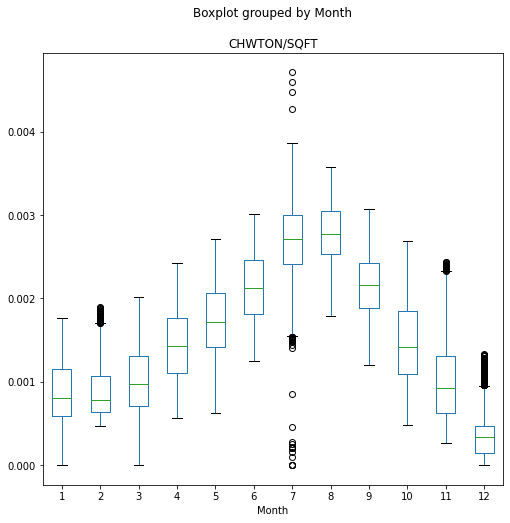

In [289]:
# Show df columns to select for boxplot
x = Bldg_Big[bldgnum_B].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg_Big[bldgnum_B]['bldgname'][0])
Bldg_Big[bldgnum_B].boxplot(by='Month', column=x[colname], grid = False, figsize = (8,8))

### 3.2.2 Time Series

In [323]:
### will work on create Date and Time column for big data to visualize vs Limited Data

# 4. Single Building Analysis - Limited Data

## 4.1 Select Building

In [316]:
# Ask user to select building
for i in range(len(Bldg_Lim)):
    print(i, Bldg_Lim[i]['bldgname'][0])

bldgnum_L = int(input("Enter the number of the building from the list above: "))

Bldg_Lim[bldgnum_L].head()

0 ISTB 2
1 Noble Library
2 Psychology
3 Schwada COB
4 Goldwater
5 Biodesign A
6 Biodesign C
7 Bulldog Hall
8 Psychology North
9 ISTB 4
10 Biodesign B
Enter the number of the building from the list above: 2


,bldgname,Date,Time,Month,Day,Hour,Minute,Air Temp,Rel Hum,KW,CHWTON,CHWTON/SQFT
0,Psychology,2018-05-16,05:00,5,16,5,0,23.438443,21.523566,108.45,120.18,0.001720
1,Psychology,2018-05-16,05:15,5,16,5,15,23.914056,24.374523,108.68,129.16,0.001849
2,Psychology,2018-05-16,05:30,5,16,5,30,23.775401,23.998164,109.12,112.29,0.001607
3,Psychology,2018-05-16,05:45,5,16,5,45,23.674907,24.049482,117.51,139.02,0.001990
4,Psychology,2018-05-16,06:00,5,16,6,0,23.553148,24.308337,122.35,139.27,0.001993


## 4.2 EDA

### 4.2.1 Boxplots

0 bldgname
1 Date
2 Time
3 Month
4 Day
5 Hour
6 Minute
7 Air Temp
8 Rel Hum
9 KW
10 CHWTON
11 CHWTON/SQFT
Enter the number of the following data columns to graph boxplot: 11

 Psychology


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


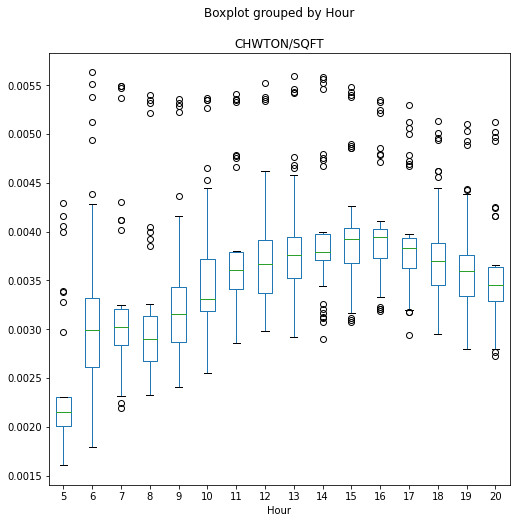

In [317]:
# Show df columns to select for boxplot
x = Bldg_Lim[bldgnum_L].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg_Lim[bldgnum_L]['bldgname'][0])
Bldg_Lim[bldgnum_L].boxplot(by='Hour', column=x[colname], grid = False, figsize = (8,8))

### 4.2.2 Time Series

Month available:<br>
May: 16, 23 <br>
June: 7, 8, 20, 21, 25<br>
August: 3<br>
September: 11, 29<br>

Enter month number: 5

 2 day(s) found in May 

0 bldgname
1 Date
2 Time
3 Month
4 Day
5 Hour
6 Minute
7 Air Temp
8 Rel Hum
9 KW
10 CHWTON
11 CHWTON/SQFT
Enter y-axis from column list above: 11


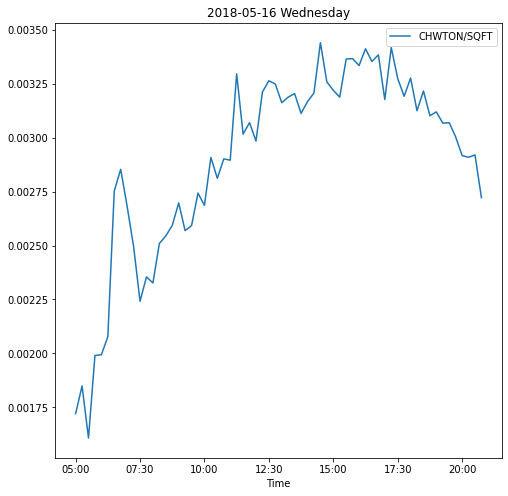

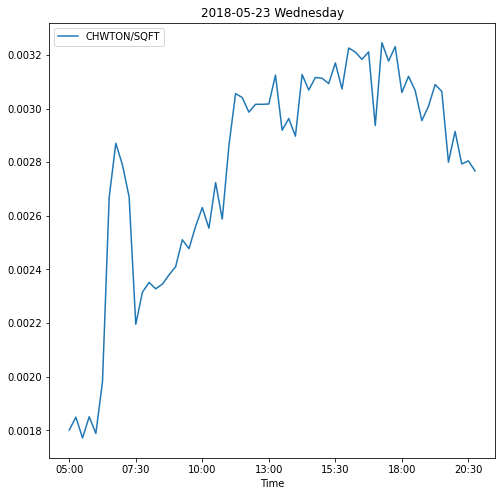

In [318]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg_Lim[bldgnum_L]['Month'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg_Lim[bldgnum_L][(Bldg_Lim[bldgnum_L]['Month'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

### 4.2.3 Correlation Matrix

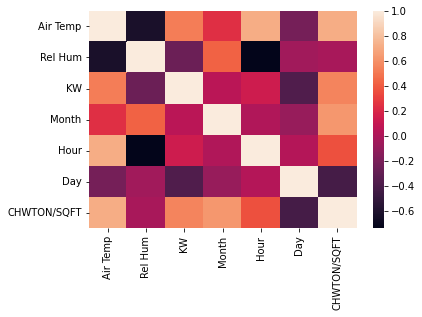

In [319]:
corr_pd = pd.DataFrame(Bldg_Lim[bldgnum_L][['Time','Air Temp','Rel Hum','KW','Month','Hour','Day', 'CHWTON/SQFT']])
corrMatrix = corr_pd.corr()
sns.heatmap(corrMatrix)

# 5. Train Models on both datasets 

## 5.1 Define Generalized Model Functions

In [324]:
#using single layer ANN. Model Parameters: hidden layer- 10 neurons, output layer- 1 neuron
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
def prepare_data(dataset):
    Y = dataset['CHWTON/SQFT']
    X = dataset[['Air Temp', 'Rel Hum']]
    Y= Y.values.reshape(-1, 1)
    # create scaler
    scaler1 = StandardScaler()
    X_scaled = scaler1.fit_transform(X)
    print(X_scaled.shape)
    # #do for output variables
    scaler2 = StandardScaler()
    Y_scaled = scaler2.fit_transform(Y)
    X_scaled = np.asarray(X_scaled).astype('float32')
    Y_scaled = np.asarray(Y_scaled).astype('float32')
    return X_scaled,Y_scaled
def define_model(activation_type, hidden_layers):
    model = Sequential()
    if activation_type == 'leaky_relu':
        model.add(Dense(10, input_dim=2, kernel_initializer='he_normal'))
        model.add(LeakyReLU(alpha=0.1))
        for i in range(0,(hidden_layers-2)):
            model.add(Dense(8))
            model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(12))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(1, activation='linear'))
    else:
        model.add(Dense(10, input_dim=2, kernel_initializer='he_normal', activation=activation_type))
        for i in range(0,(hidden_layers-2)):
            model.add(Dense(8, activation=activation_type))
        model.add(Dense(12, activation=activation_type))
        model.add(Dense(1, activation='linear'))
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics = ['mse','mae'])
    return model
def plot_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
def evaluate(model,X,Y):
    #evaluate on test dataset, add evaluation parameters
    Y_preds = model.predict(X)
    RMSE = np.sqrt(metrics.mean_squared_error(Y, Y_preds))
    test_loss = model.evaluate(X, Y)
    return RMSE, test_loss

## 5.2 Prepare Data for feeding into training loop

In [326]:
# Limited Data
X_limited,y_limited = prepare_data(Bldg_Lim[bldgnum_L])
X_limited_train, X_limited_test, y_limited_train,y_limited_test = train_test_split(X, y, test_size=0.2, random_state=20)
X,Y = prepare_data(Bldg_Big[bldgnum_B])
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

(638, 2)
(34624, 2)


In [332]:
X_limited_test

,Air Temp,Rel Hum
193,37.192846,8.677207
14,27.580720,21.991502
163,27.638618,21.178537
93,26.946125,23.423542
319,29.886466,23.664887
...,...,...
733,36.395348,17.343559
411,37.556784,12.746310
660,39.160002,15.440335
351,39.447147,9.197441


## 5.3 Hyperparameter Tuning experiments

In [ ]:
activation_functions = ['relu','elu','selu','leaky_relu','tanh']
no_hidden_layers = [1,3,5,7,9,11]
row_headings = ['1','3','5','7','9','11']
eval_func = []
for func in activation_functions:
    eval_func_layers = []
    for hl in no_hidden_layers:
        model = define_model(func,hl)
        history = model.fit(X_train, Y_train, batch_size=128, epochs=100,  validation_split=0.2)
        RMSE, _ = evaluate(model, X_test, Y_test)
        eval_func_layers.append(RMSE)
    eval_func.append(eval_func_layers)
print(eval_func)   
tab = pd.DataFrame(eval_func, activation_functions, row_headings)
print(tab)
        


## 5.4 Train Model with Optimized hyperparameters

In [ ]:
base_model = define_model('relu',3)
history = base_model.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.2)

## 5.5 Evaluate Base Model with Big Dataset and Limited Dataset

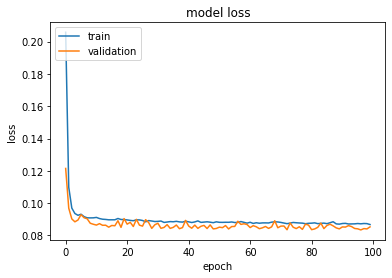

NameError: ignored

In [35]:
plot_curve(history)
RMSE, _ = evaluate(base_model, X_test, Y_test)
RMSE_base, _ = evaluate(base_model, X_limited,Y_limited)
print(RMSE)
print(RMSE_base)

## 5.6 Transfer features and Fine Tune Base Model on Limited Dataset

In [ ]:
def fine_tune(model):
    model.trainable = True
    print("Number of layers in the base model: ", len(base_model.layers))
    # Fine-tune from this layer onwards
    fine_tune_at = 1
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[:fine_tune_at]:
      layer.trainable =  False
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics = ['mse','mae'])
    return model
fine_tuned_model = fine_tune(base_model)
X_limited,Y_limited = prepare_data(envimet)
history = fine_tuned_model.fit(X_limited,Y_limited, epochs=50, verbose=1)

Number of layers in the base model:  4
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 12)                36        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 241
Trainable params: 205
Non-trainable params: 36
_________________________________________________________________
(16, 2)
Epoch 1/50
1/1 [==============================] - 0s 757us/step - loss: 0.3919 - mse: 0.3919 - mae: 0.5261
Epoch 2/50
1/1 [==============================] - 0s 806us/step - loss: 0.3882 - mse: 0.3882 - mae:

## 5.7 Evaluate Fine-tuned Model on Limited Dataset

In [ ]:
RMSE_fine_tune ,_= evaluate(fine_tuned_model,X_limited,Y_limited)
print(RMSE_fine_tune)

1/1 [==============================] - 0s 726us/step - loss: 0.2657 - mse: 0.2657 - mae: 0.4237
0.51549023
